# Colapse all simulation into a unique .feather file

In [1]:
import glob, os
import urllib.request, ssl
import pandas as pd
import numpy as np
from scipy.stats import ecdf, wasserstein_distance

import matplotlib.pyplot as plt
import seaborn as sns
from convergence_analysis import mean_variance_convergence

def download_file(url, local_filename):
    # Create an SSL context that does not verify certificates
    context = ssl._create_unverified_context()
    # Open the URL with the context and read the content
    with urllib.request.urlopen(url, context=context) as response:
        content = response.read()
    # Write the content to the local file
    with open(local_filename, 'wb') as file:
        file.write(content)

def generate_complete_data():       
    df_complete_file = 'df_complete_ex3.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
    if ( os.path.exists(df_complete_file) ):
        print(f'{df_complete_file} already exists. Reading it.')
        # df_all = pd.read_feather(df_complete_file)
    else:
        print(f'{df_complete_file} does not exists. Generating it.')
        data_files = glob.glob('../output_SA_ex3/SummaryFile_*.feather')
        df_all = pd.concat((pd.read_feather(file) for file in data_files), ignore_index=True)
        # Add the new column with parameter value to IC immune fraction
        df_all['IC_immune_frac'] = 1
        # Define the values to be assigned to samples 1-8 with diff IC proportions
        immune_frac_values = [0.99, 1.01, 0.95, 1.05, 0.9,1.1, 0.8, 1.2]
        # Assign the values to the corresponding samples
        for i, value in enumerate(immune_frac_values, start=1):
            df_all.loc[df_all['sample'] == i, 'IC_immune_frac'] = value
        # Save the dataframe to a feather file
        df_all.to_feather(df_complete_file)
    return df_all

params_list = ['phago_rate_apop', 'phago_rate_nec', 'mac_antinf_secretion_base',
       'attack_duration', 'cd8_migr_speed_base', 'damage_apop_sat',
       'damage_apop_hfm', 'damage_apop_hp', 'dead_debris_sat',
       'dead_debris_hfm', 'dead_debris_hp', 'mac_oxy_proinf_sat',
       'mac_oxy_proinf_hfm', 'mac_oxy_proinf_hp', 'mac_oxy_antinf_hfm',
       'mac_oxy_antinf_hp', 'cd8_antinf_attack_hfm', 'cd8_antinf_attack_hp',
       'cd8_proinf_attack_sat', 'cd8_proinf_attack_hfm',
       'cd8_proinf_attack_hp', 'cd8_antinf_speed_hfm', 'cd8_antinf_speed_hp',
       'cd8_contact_speed_hfm', 'cd8_contact_speed_hp', 'IC_immune_frac']

# Define the QoIs: AUC of tumor population, distribution of cell distance from the center at the last time

- Population: store the population of each cell type over time.
    - Summary over time: Area under curve (AUC) of the populations.
- Invasion: Distance of cells from the center - provides insights into the spatial distribution and invasion characteristics of the cells.
    - Summary over space: Pool the distances from the center and calculate the Wassertein distance between tumor and CD8 T cells, and tumor and macrophages.


In [2]:
# 1,264,450 rows = 209 samples * 50 repplicates * 121 time points 
df_qoi_file = 'df_qoi_ex3.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
df_summary_file = 'df_summary_ex3.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather

def calculate_qoi_summary():
    print(f'{df_summary_file} or {df_qoi_file} does not exist. Generating it.')
    df_all = generate_complete_data()
    # Sum tumor_apop and tumor_nec columns into a single column called tumor_dead
    df_all['tumor_dead'] = df_all['tumor_apop'] + df_all['tumor_nec']
    df_all.drop(['tumor_apop', 'tumor_nec'], axis=1, inplace=True)
    # Calculate the AUC for each sample and replicate
    def calculate_auc_wassertein_dist(group):
        auc_values = {}
        for col in ['tumor_live', 'tumor_dead','mac_pif_secretion','mac_aif_secretion']: # QoI columns of cell population  
            mask_notna = group[col].notna()  
            auc_values[f'AUC_{col}'] = np.trapz(group[col][mask_notna], group['time'][mask_notna])
        wasserstein_values = {}
        subgroup = group[group['time'] == 7200.0] # select the last time point
        # Check if there is no tumor cells at the last time point
        try:
            emp_tumor_cdf = ecdf(subgroup['dist_tumor'].values[0])
            emp_mac_cdf = ecdf(subgroup['dist_mac'].values[0])
            emp_cd8_cdf = ecdf(subgroup['dist_cd8'].values[0])
            wasserstein_values['Wasserstein_dist_Mac'] = wasserstein_distance(emp_tumor_cdf.cdf.quantiles, emp_mac_cdf.cdf.quantiles, emp_tumor_cdf.cdf.probabilities, emp_mac_cdf.cdf.probabilities)
            wasserstein_values['Wasserstein_dist_CD8'] = wasserstein_distance(emp_tumor_cdf.cdf.quantiles, emp_cd8_cdf.cdf.quantiles, emp_tumor_cdf.cdf.probabilities, emp_cd8_cdf.cdf.probabilities)
        except Exception as e:
            print(f'Error calculating Wasserstein distance for sample {subgroup["sample"].values[0]} and replicate {subgroup["replicate"].values[0]}: {e}')
            print(f'Number of tumor cells: {len(subgroup["dist_tumor"].values[0])}, Number of Macrophages: {len(subgroup["dist_mac"].values[0])}, Number of CD8: {len(subgroup["dist_cd8"].values[0])}')
            wasserstein_values['Wasserstein_dist_Mac'] = np.inf
            wasserstein_values['Wasserstein_dist_CD8'] = np.inf
        return pd.Series({**auc_values, **wasserstein_values})

    # Concatenate the dist_tumor_live and dist_tumor_apop and dist_tumor_nec columns into a single column - [Tumor = Live + Apop + Nec]
    df_all['dist_tumor'] = df_all.apply(lambda row: np.concatenate([row['dist_tumor_live'], row['dist_tumor_apop'], row['dist_tumor_nec']]), axis=1)
    df_all.drop(['dist_tumor_live', 'dist_tumor_apop', 'dist_tumor_nec'], axis=1, inplace=True)
    # Group by 'SampleID' and 'replicate' then calculate AUC and Wassertein distance for each QOI - row dimension of samples x replicates
    df_qoi = df_all.groupby(['sample', 'replicate']).apply(calculate_auc_wassertein_dist).reset_index()
    # Drop outliers: distance = inf (no tumor cells)
    df_qoi = df_qoi[(df_qoi['Wasserstein_dist_Mac'] != np.inf) & (df_qoi['Wasserstein_dist_CD8'] != np.inf)] # two replicates with no tumor cells: Sample_49_Rep_23 and Sample_187_Rep_10
    # Add the parameter values to the QoI dataframe
    df_qoi = df_qoi.merge(df_all[['sample', 'replicate'] + params_list], on=['sample', 'replicate'], how='left').drop_duplicates().reset_index(drop=True)
    
    # Calculate the mean and standard deviation of the QoI for each sample
    df_summary = df_qoi.groupby(['sample']).agg({'AUC_tumor_live': ['mean', 'std'], 'AUC_tumor_dead': ['mean', 'std'], 'AUC_mac_pif_secretion': ['mean', 'std'], 'AUC_mac_aif_secretion': ['mean', 'std'], 'Wasserstein_dist_Mac': ['mean', 'std'], 'Wasserstein_dist_CD8': ['mean', 'std']}).reset_index()
    df_summary.columns = ['_'.join(col) if col[1] else col[0] for col in df_summary.columns]
    # Add the parameter values to the summary dataframe
    df_summary = df_summary.merge(df_qoi[['sample'] + params_list], on=['sample'], how='left').drop_duplicates().reset_index(drop=True)
    
    # Save the dataframes to feather files
    df_qoi.to_feather(df_qoi_file)
    df_summary.to_feather(df_summary_file)

    return df_qoi, df_summary


if ( os.path.exists(df_summary_file) & os.path.exists(df_qoi_file) ):
    print(f'{df_summary_file} and {df_qoi_file} already exists. Reading it.')
    df_summary = pd.read_feather(df_summary_file)
    df_qoi = pd.read_feather(df_qoi_file)
else:
    # Download the summary and qois dataframes 
    print("Downloading summary and qois dataframes...")
    url_qois = "https://zenodo.org/records/14590312/files/df_qoi_ex3.feather?download=1"
    url_summary = "https://zenodo.org/records/14590312/files/df_summary_ex3.feather?download=1"
    # Create an SSL context that does not verify certificates
    context = ssl._create_unverified_context()
    download_file(url_qois, df_qoi_file)
    download_file(url_summary, df_summary_file)
    df_qoi = pd.read_feather(df_qoi_file)
    df_summary = pd.read_feather(df_summary_file)
    print("Dataframes downloaded.")
    # df_qoi, df_summary = calculate_qoi_summary()
   

print(df_qoi.shape)
print(df_summary.shape)
df_summary

df_summary_ex3.feather and df_qoi_ex3.feather already exists. Reading it.
(10448, 34)
(209, 39)


,sample,AUC_tumor_live_mean,AUC_tumor_live_std,AUC_tumor_dead_mean,AUC_tumor_dead_std,AUC_mac_pif_secretion_mean,AUC_mac_pif_secretion_std,AUC_mac_aif_secretion_mean,AUC_mac_aif_secretion_std,Wasserstein_dist_Mac_mean,...,cd8_antinf_attack_hfm,cd8_antinf_attack_hp,cd8_proinf_attack_sat,cd8_proinf_attack_hfm,cd8_proinf_attack_hp,cd8_antinf_speed_hfm,cd8_antinf_speed_hp,cd8_contact_speed_hfm,cd8_contact_speed_hp,IC_immune_frac
0,0,7240781.4,467114.888516,2715863.4,133837.825525,50792.172022,2976.980188,21207.827978,2976.980188,85.858287,...,0.5,8.0,1.0,0.5,8.0,0.5,8.0,0.5,8.0,1.00
1,1,7249698.0,405783.615062,2702886.6,147884.318532,50593.103208,2687.662137,21406.896792,2687.662137,81.732291,...,0.5,8.0,1.0,0.5,8.0,0.5,8.0,0.5,8.0,0.99
2,2,7347319.8,472425.988668,2745535.2,135017.869070,50492.996165,3155.274479,21507.003835,3155.274479,72.342017,...,0.5,8.0,1.0,0.5,8.0,0.5,8.0,0.5,8.0,1.01
3,3,7345020.6,567694.914924,2748511.2,122516.406076,50449.845860,3763.386308,21550.154140,3763.386308,71.375166,...,0.5,8.0,1.0,0.5,8.0,0.5,8.0,0.5,8.0,0.95
4,4,7283129.4,470798.719132,2744153.4,124892.824676,50739.563335,3212.109798,21260.436665,3212.109798,83.117825,...,0.5,8.0,1.0,0.5,8.0,0.5,8.0,0.5,8.0,1.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,204,7324340.4,457323.773839,2730448.2,131514.086678,50241.556921,3025.722748,21758.443079,3025.722748,72.766223,...,0.5,8.0,1.0,0.5,8.0,0.5,8.0,0.5,8.4,1.00
205,205,7279527.6,535063.173053,2733967.8,122170.178420,50600.759529,3476.499593,21399.240471,3476.499593,82.103207,...,0.5,8.0,1.0,0.5,8.0,0.5,8.0,0.5,7.2,1.00
206,206,7247568.0,446052.755743,2740980.0,136449.764876,50562.158334,3053.966315,21437.841666,3053.966315,79.336540,...,0.5,8.0,1.0,0.5,8.0,0.5,8.0,0.5,8.8,1.00
207,207,7256892.6,537130.756721,2732553.6,140858.930295,50663.487954,3544.769234,21336.512046,3544.769234,78.863829,...,0.5,8.0,1.0,0.5,8.0,0.5,8.0,0.5,6.4,1.00


Sample with reference parameters:  [1.0e-01 1.7e-02 1.0e+01 1.5e+01 1.0e+00 2.3e-02 4.5e+01 1.6e+01 1.7e-02
 1.0e-01 1.0e+01 1.0e+01 1.2e+01 1.6e+01 1.2e+01 1.6e+01 5.0e-01 8.0e+00
 1.0e+00 5.0e-01 8.0e+00 5.0e-01 8.0e+00 5.0e-01 8.0e+00 1.0e+00]


/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


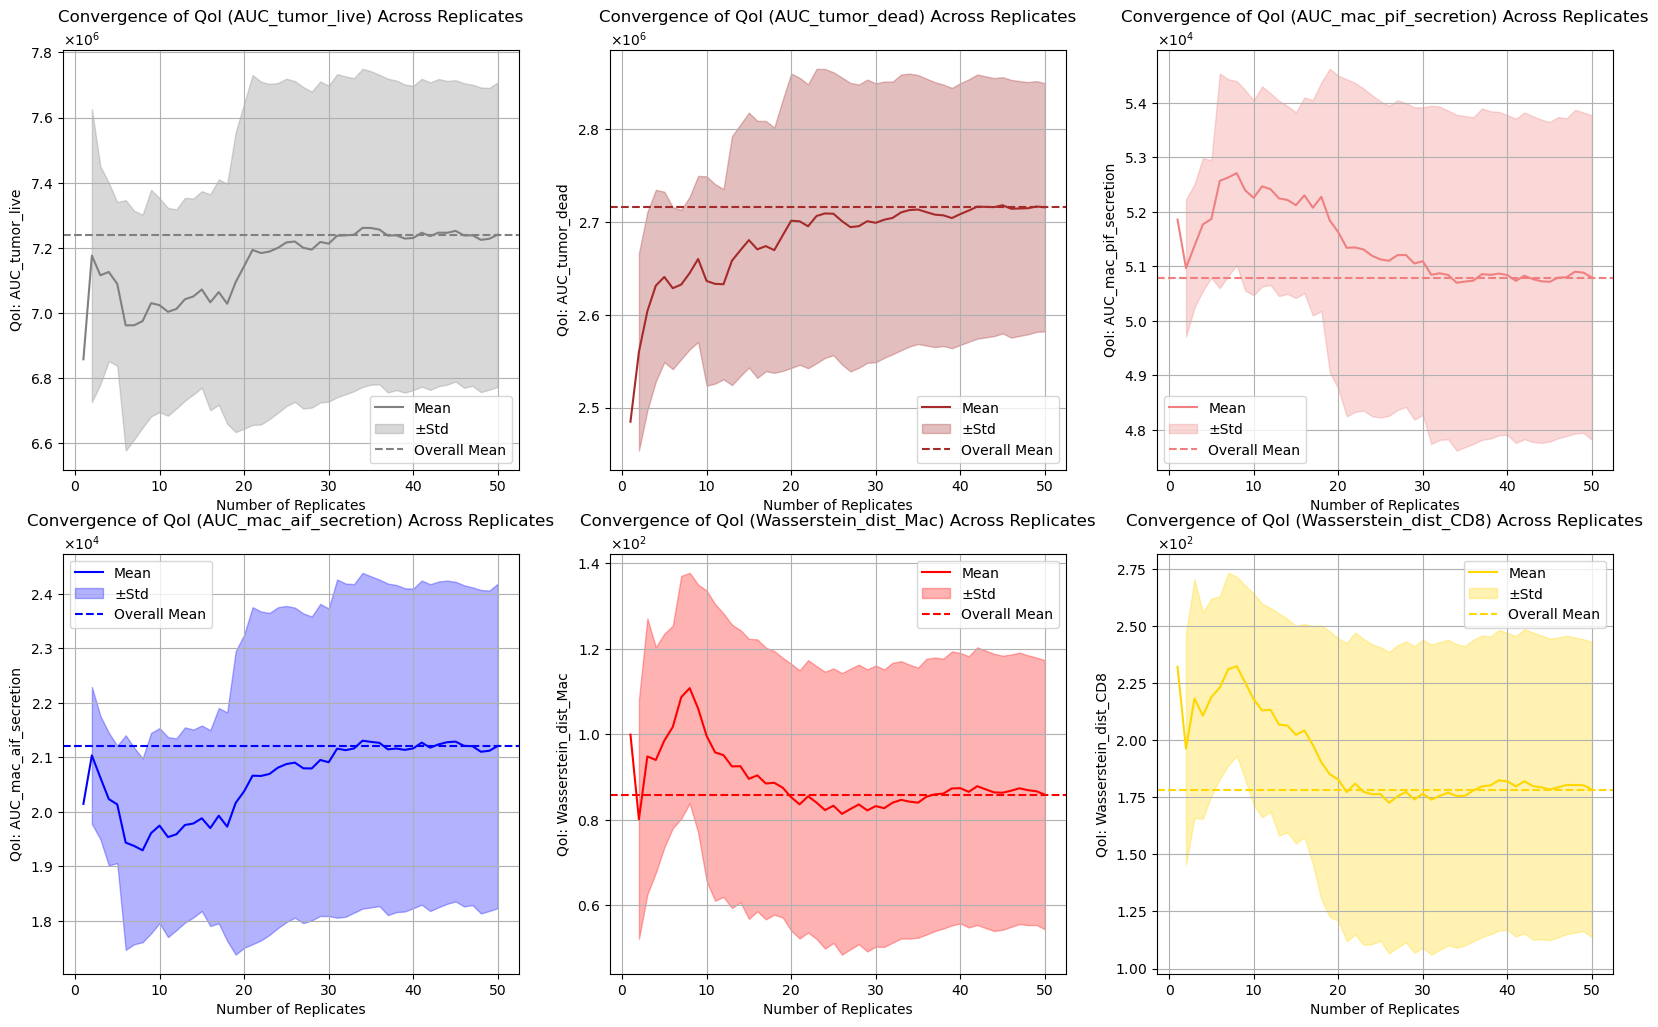

In [3]:
sample_ref = 0 # Sample with reference parameters
print('Sample with reference parameters: ', df_summary.iloc[sample_ref][params_list].values)
QoIs_list = ['AUC_tumor_live', 'AUC_tumor_dead', 'AUC_mac_pif_secretion', 'AUC_mac_aif_secretion', 'Wasserstein_dist_Mac', 'Wasserstein_dist_CD8']
colors = ['gray', 'brown', 'lightcoral', 'blue', 'red', 'gold']
figure1, axes = plt.subplots(2, 3, figsize=(20, 12))
for qoi, color, ax in zip(QoIs_list, colors, axes.flatten()):
    data = df_qoi.loc[ df_qoi['sample'] == sample_ref][qoi].values
    # Calculate running mean and variance for the QoI
    running_means, running_var = mean_variance_convergence(data)
    running_stds = np.sqrt(running_var)
    # Plot the running mean and standard deviation
    x = np.arange(1, len(data) + 1)
    ax.plot(x, running_means, label='Mean', color=color)
    ax.fill_between(x, running_means - running_stds, running_means + running_stds, alpha=0.3, label='±Std', color=color)
    ax.axhline(np.mean(data), color=color, linestyle='--', label='Overall Mean')
    ax.set_xlabel('Number of Replicates')
    ax.set_ylabel(f'QoI: {qoi}')
    ax.set_title(f'Convergence of QoI ({qoi}) Across Replicates')
    ax.grid()
    ax.legend()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True
plt.show()
figure1.savefig('Replicates_immune.svg', format='svg')

# Local sensitivity analysis: 
Given $\theta^\star$ as the reference parameter set, we added a multiplicative perturbation $\delta$, which
$$\theta_i = \theta^\star \times (1\pm \delta), \quad \delta = \{0.01, 0.05, 0.1, 0.2\}$$

Sensitivity index:

$$\overline{SI}_{\theta_i} = \dfrac{||f(\theta_i)-f(\theta^\star)||}{\max_\delta ||f(\theta_i)-f(\theta^\star)||}$$

- $\overline{SI}_{\theta_i}=0:$ The output is insensitive to changes in the parameter.
- $\overline{SI}_{\theta_i}=1:$ The output is highly sensitive to the parameter; $\theta_i$ has the maximum impact on the QoIs compared to all other parameters and perturbations.

Interpretation:
- High $\overline{SI}_{\theta_i}$ values (closer to 1) suggest that the parameter $\theta_i$ is influential and significantly impacts the model outputs. Such parameters may require precise calibration or careful validation based on experimental or clinical data.
- Low $\overline{SI}_{\theta_i}$ values (closer to 0) indicate that the parameter $\theta_i$ has little to no effect on the QoIs. These parameters may have limited importance in the model's behavior within the tested range and could be candidates for simplification or fixed values.

In [4]:
# Calculate the sensitivity index
QoIs_list = [qoi+'_mean' for qoi in QoIs_list]
# Function to calculate SI using
def calculate_SI_multiple():
    sensitivity_analysis_dic = {}
    # Calculate the delta of parameters
    non_zero_values = []; non_zero_params= []
    relative_change_params = (df_summary[params_list] - df_summary.iloc[sample_ref][params_list].values) / np.where(df_summary.iloc[sample_ref][params_list].values != 0, df_summary.iloc[sample_ref][params_list].values, 1)
    for index, row in relative_change_params.iterrows():
        # First index is the reference sample - include the value 0 and skip it
        if index == sample_ref: non_zero_values.append(0); non_zero_params.append('Reference'); continue
        # Get the non-zero values in the row
        non_zero_row_values = row[row != 0.0]
        # Check if there is exactly one non-zero value
        if len(non_zero_row_values) == 1: non_zero_values.append(non_zero_row_values.iloc[0])
        else: raise ValueError(f"Row {index} contains more than one non-zero value or all values are zero. Non zero: {non_zero_row_values} - Row: {row.values}")
        # Parameter name with non-zero value
        non_zero_params.append(non_zero_row_values.index[0])
    relative_change_params_1d = pd.DataFrame(non_zero_values, columns=['NonZeroValues'])
    sensitivity_analysis_dic['SA_parameter'] = np.array(non_zero_params)
    sensitivity_analysis_dic['SA_delta'] = relative_change_params_1d.to_numpy()[:,0].round(2)
    # Calculate the delta of QoIs
    absolute_change_qois = abs(df_summary[QoIs_list] - df_summary.iloc[sample_ref][QoIs_list].values)
    max_diff_qois = absolute_change_qois.max()
    normalized_change_qois = absolute_change_qois / max_diff_qois
    for id_qoi, qoi in enumerate(QoIs_list): 
        sensitivity_analysis_dic[f'SI_{qoi}'] = normalized_change_qois.to_numpy()[:,id_qoi]
    
    # Change the delta of reference value to 0 and label it as reference
    return pd.DataFrame(sensitivity_analysis_dic)

# Group by 'Sample_ID' then calculate AUC for each QOI - row dimension of samples
df_SA = calculate_SI_multiple() # calculate the AUC for each QOI
df_SA = pd.concat([df_summary['sample'], df_SA], axis=1)

# Print the sensitivity index
for qoi in QoIs_list:
    sample_lowest_qoi = df_summary.iloc[df_summary[qoi].idxmin()]['sample']; sample_highest_qoi = df_summary.iloc[df_summary[qoi].idxmax()]['sample']
    sample_lowest_si = df_SA.iloc[df_SA[f'SI_{qoi}'].idxmin()]['sample']; sample_highest_si = df_SA.iloc[df_SA[f'SI_{qoi}'].idxmax()]['sample']
    print(f"QoI: {qoi}")
    print(f"\t lowest and highest QoI: Sample {int(sample_lowest_qoi)} ({df_SA.iloc[int(sample_lowest_qoi)]['SA_parameter']}) and Sample {int(sample_highest_qoi)} ({df_SA.iloc[int(sample_highest_qoi)]['SA_parameter']})")
    print(f"\t lowest and highest SI: Sample {int(sample_lowest_si)} ({df_SA.iloc[int(sample_lowest_si)]['SA_parameter']}) and Sample {int(sample_highest_si)} ({df_SA.iloc[int(sample_highest_si)]['SA_parameter']})\n")
df_SA

QoI: AUC_tumor_live_mean
	 lowest and highest QoI: Sample 48 (cd8_migr_speed_base) and Sample 112 (mac_oxy_proinf_hfm)
	 lowest and highest SI: Sample 0 (Reference) and Sample 112 (mac_oxy_proinf_hfm)

QoI: AUC_tumor_dead_mean
	 lowest and highest QoI: Sample 111 (mac_oxy_proinf_hfm) and Sample 112 (mac_oxy_proinf_hfm)
	 lowest and highest SI: Sample 0 (Reference) and Sample 111 (mac_oxy_proinf_hfm)

QoI: AUC_mac_pif_secretion_mean
	 lowest and highest QoI: Sample 112 (mac_oxy_proinf_hfm) and Sample 111 (mac_oxy_proinf_hfm)
	 lowest and highest SI: Sample 0 (Reference) and Sample 112 (mac_oxy_proinf_hfm)

QoI: AUC_mac_aif_secretion_mean
	 lowest and highest QoI: Sample 127 (mac_oxy_antinf_hfm) and Sample 128 (mac_oxy_antinf_hfm)
	 lowest and highest SI: Sample 0 (Reference) and Sample 128 (mac_oxy_antinf_hfm)

QoI: Wasserstein_dist_Mac_mean
	 lowest and highest QoI: Sample 128 (mac_oxy_antinf_hfm) and Sample 111 (mac_oxy_proinf_hfm)
	 lowest and highest SI: Sample 0 (Reference) and Sam

,sample,SA_parameter,SA_delta,SI_AUC_tumor_live_mean,SI_AUC_tumor_dead_mean,SI_AUC_mac_pif_secretion_mean,SI_AUC_mac_aif_secretion_mean,SI_Wasserstein_dist_Mac_mean,SI_Wasserstein_dist_CD8_mean
0,0,Reference,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,IC_immune_frac,-0.01,0.002707,0.024421,0.006762,0.008376,0.076220,0.099604
2,2,IC_immune_frac,0.01,0.032345,0.055839,0.010162,0.012589,0.249689,0.230918
3,3,IC_immune_frac,-0.05,0.031647,0.061439,0.011628,0.014405,0.267550,0.240405
4,4,IC_immune_frac,0.05,0.012857,0.053238,0.001787,0.002214,0.050625,0.091531
...,...,...,...,...,...,...,...,...,...
204,204,cd8_contact_speed_hp,0.05,0.025369,0.027447,0.018703,0.023169,0.241852,0.224341
205,205,cd8_contact_speed_hp,-0.10,0.011763,0.034070,0.006502,0.008054,0.069368,0.166790
206,206,cd8_contact_speed_hp,0.10,0.002060,0.047266,0.007813,0.009679,0.120478,0.066083
207,207,cd8_contact_speed_hp,-0.20,0.004891,0.031409,0.004371,0.005415,0.129210,0.058542


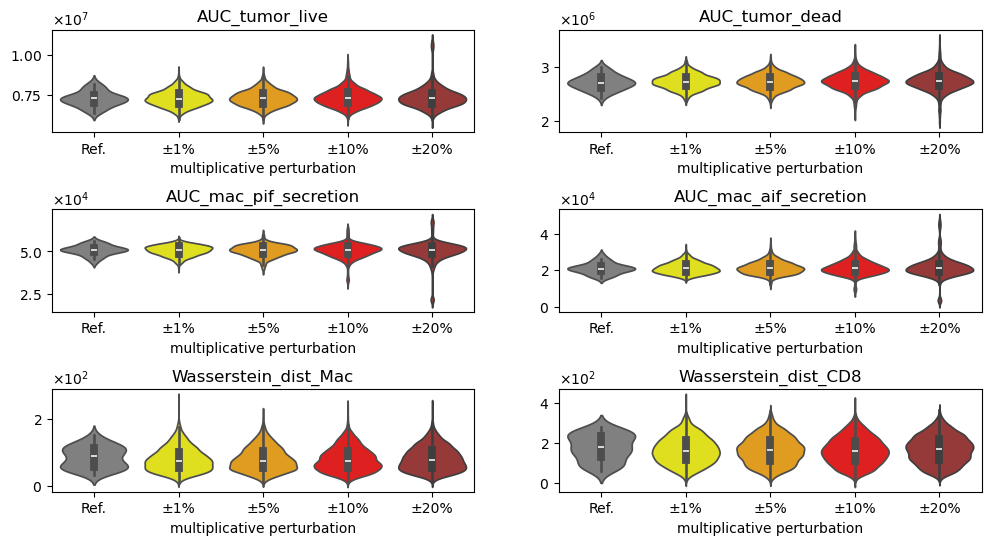

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.75)
for qoi, ax in zip(QoIs_list, axes.flatten()):
    # Plot a box plot for each QoI (x axis: SA_delta, y axis: QoI value)
    # ax.boxplot([df_all[df_summary['sample'] == sample][qoi].values for sample in [sample_ref, *samples_deltap1, *samples_deltam1, *samples_deltap5, *samples_deltam5, *samples_deltap10, *samples_deltam10, *samples_deltap20, *samples_deltam20]], showfliers=False)
    for delta, color in zip([0.0, 0.01, 0.05, 0.1, 0.2], 
                            ['gray', 'yellow', 'orange', 'red', 'brown']):
        samples = df_SA[ (df_SA['SA_delta'] == delta) | (df_SA['SA_delta'] == -1*delta) ]['sample'].values
        values = df_qoi[df_qoi['sample'].isin(samples)][qoi[:-5]].values
        sns.violinplot(x=[delta*100]*len(values), y=values, ax=ax, color=color)
    
    # change the x ticks label adding +- sign
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(['Ref.', '±1%', '±5%', '±10%', '±20%'])
    ax.set_title(qoi[:-5])
    ax.set_xlabel('multiplicative perturbation')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True
# plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))


plt.show()
fig.savefig('QoIs_immune.svg', format='svg')

/var/folders/z0/qjtn97gj62z2_f7wmwlwkvmc0000gn/T/ipykernel_18503/3345334863.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SA["SA_delta"] = df_SA["SA_delta"] * 100


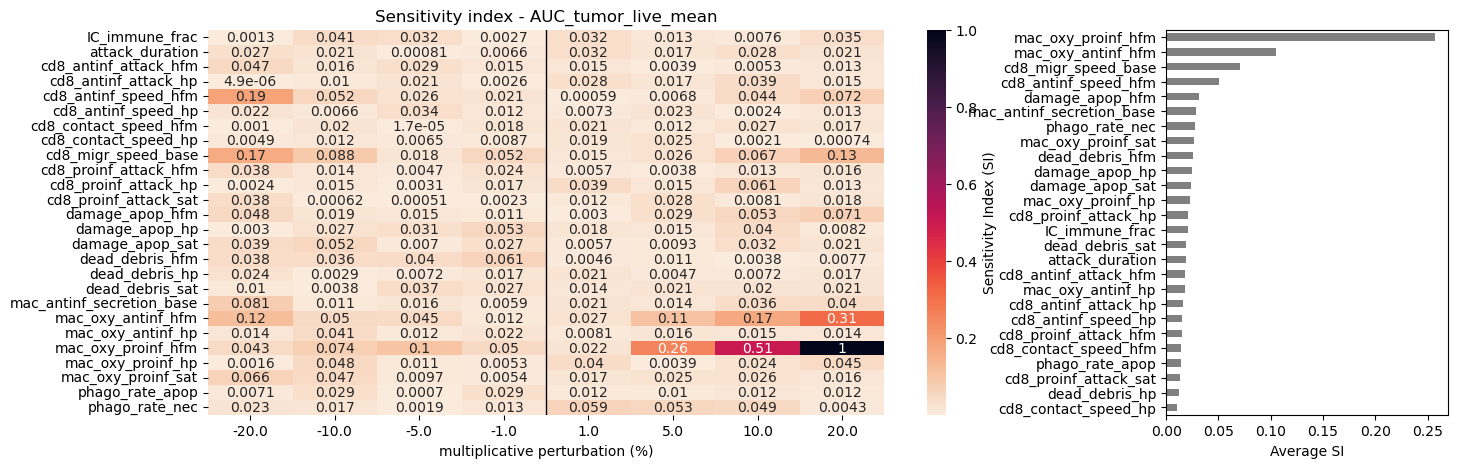

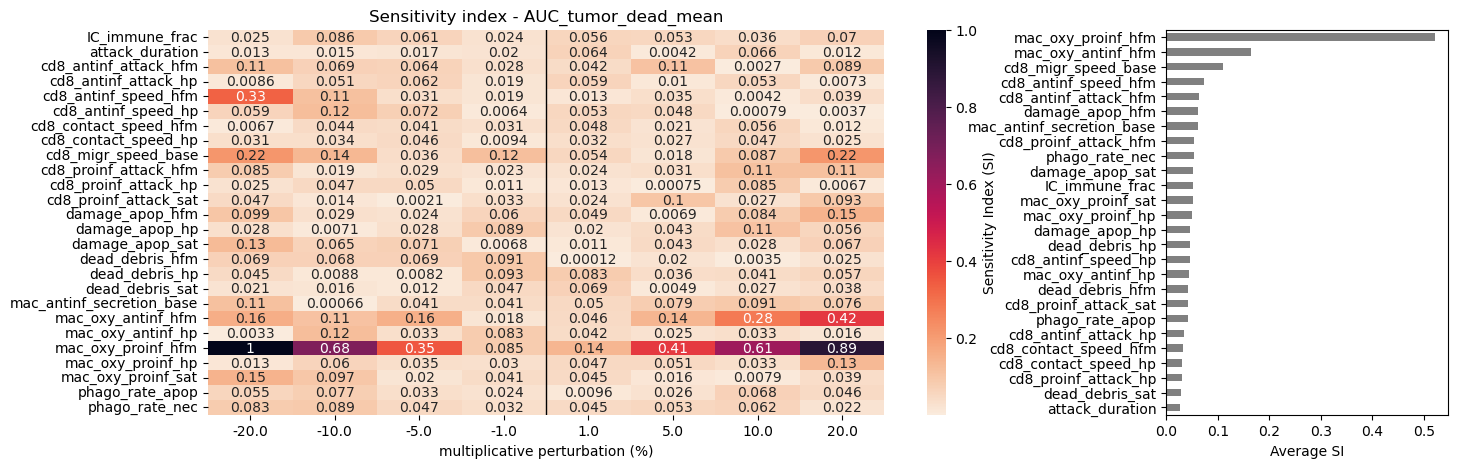

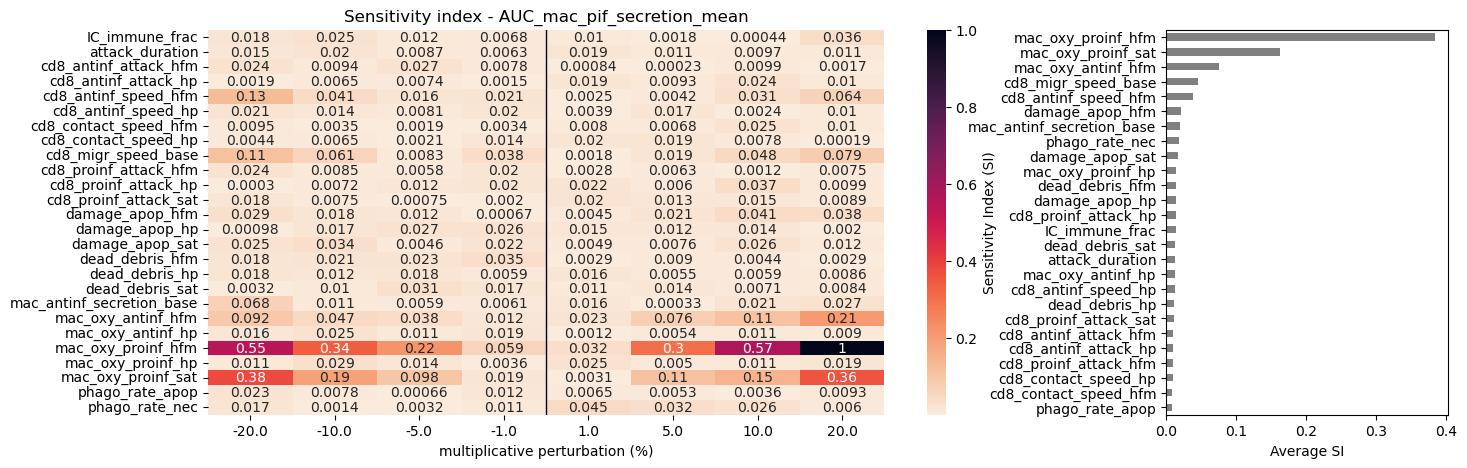

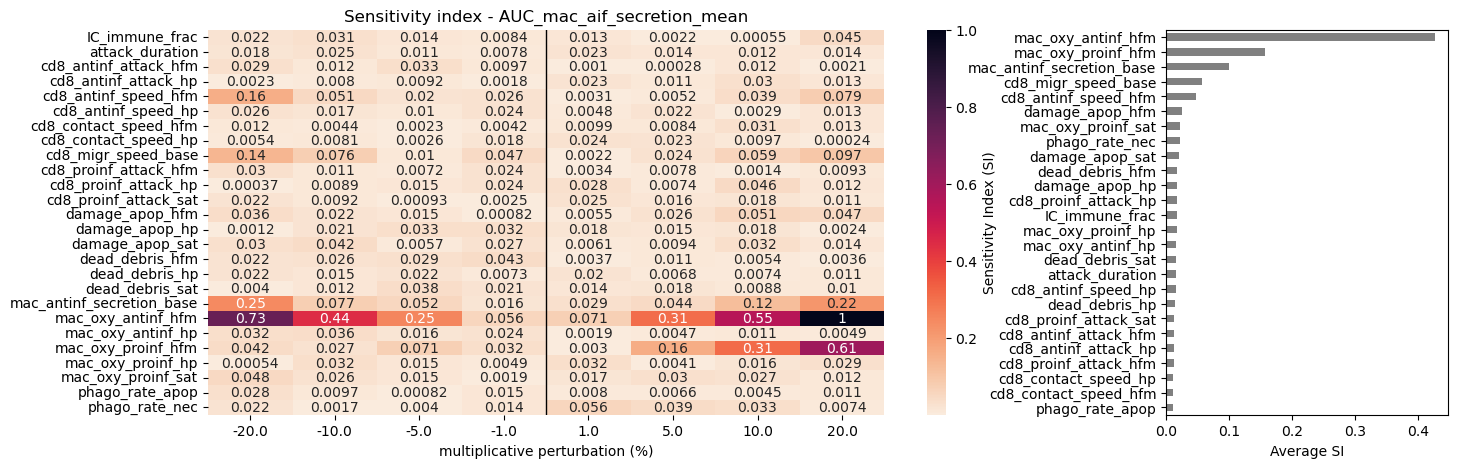

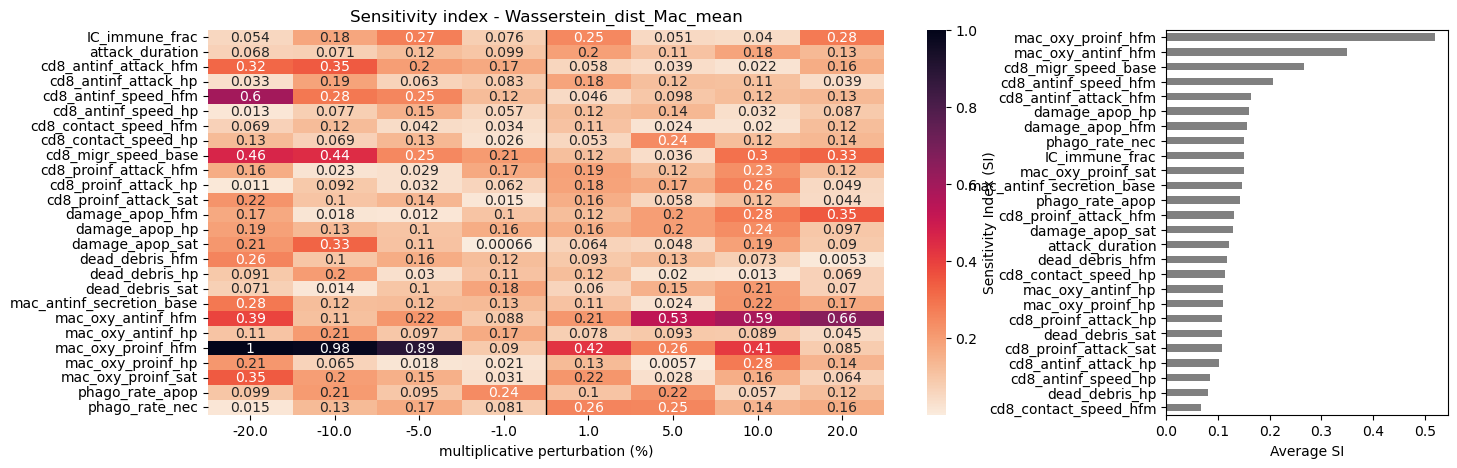

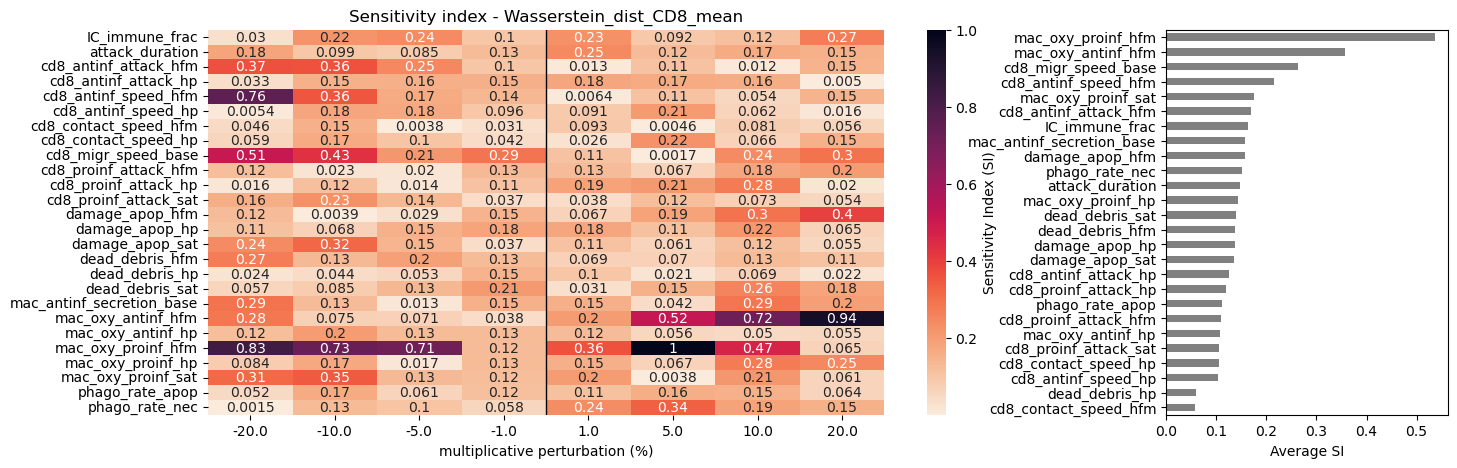

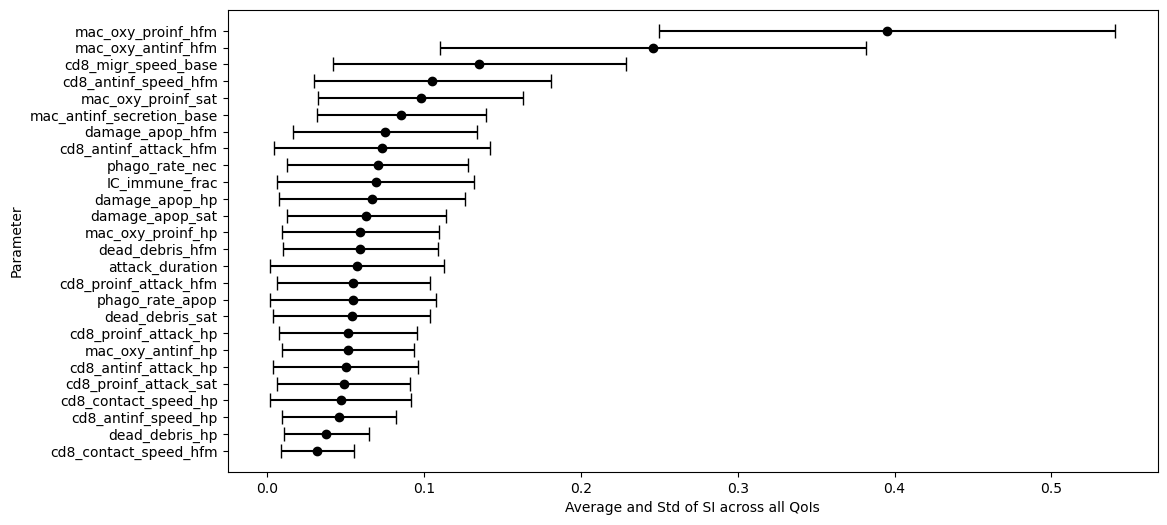

In [6]:
# Drop the reference sample
df_SA = df_SA[df_SA['sample'] != sample_ref]
# Convert the multiplicative perturbation to percentage
df_SA["SA_delta"] = df_SA["SA_delta"] * 100
dict_SI = {}
# Plot the parameter according to the sensitivity index as heatmap with the parameters vs delta and color as the SI
for qoi in QoIs_list:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [3, 1]})
    # pivot the dataframe to have the parameter as index, delta as columns and sensitivity index as values
    df_SA_pivot_plot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi)
    # print(df_SA_pivot.head(),'\n')
    sns.heatmap(df_SA_pivot_plot, cmap='rocket_r', annot=True,ax=ax1)
    cbar = ax1.collections[0].colorbar
    cbar.set_label(f'Sensitivity Index (SI)')
    # draw a line to separate the positive and negative values
    ax1.axvline(4, color='black', lw=1)
    ax1.set(title = f'Sensitivity index - {qoi}', xlabel='multiplicative perturbation (%)', ylabel=None)
    # Average the RSI across all multiplicative perturbations
    dict_SI[qoi] = df_SA_pivot_plot.mean(axis=1)
    dict_SI[qoi] = dict_SI[qoi].sort_values(ascending=True)
    dict_SI[qoi].plot(kind='barh', ax=ax2, color='gray')
    ax2.set(xlabel='Average SI', ylabel=None)
plt.show()

fig2, ax = plt.subplots(figsize=(12, 6))
# Merge the sensitivity index of all QoIs and plot the average SI and std
df_SI = pd.DataFrame(dict_SI)
df_SI['mean'] = df_SI.mean(axis=1)
df_SI['std'] = df_SI.std(axis=1)
df_SI = df_SI.sort_values(by='mean', ascending=True)
ax.errorbar(df_SI['mean'], df_SI.index, xerr=df_SI['std'], fmt='o', color='k', capsize=5)
ax.set(xlabel='Average and Std of SI across all QoIs', ylabel='Parameter')
plt.show()
fig2.savefig('SI_params_immune.svg', format='svg')